<a href="https://colab.research.google.com/github/Gabomatius/MD_Anime/blob/main/Bayes_DecisionT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import re
from sklearn.impute import SimpleImputer
import sys
from sklearn import tree
from sklearn import preprocessing 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import auc, accuracy_score, precision_score, roc_curve, recall_score, confusion_matrix, f1_score, classification_report, plot_roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance
from seaborn import despine
from sklearn.pipeline import make_pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/Mineria de datos/Entrega 3/Bayes/')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('Row_data.csv', sep = ';')
data.shape

(107545, 34)

Se eliminan las variables score por ser redundantes con la variable Score target usada como etiqueta

In [ ]:
data.drop(['MAL_ID','Score-1','Score-2','Score-3','Score-4','Score-5','Score-6','Score-7','Score-8','Score-9','Score-10'], axis = 1, inplace = True)
data.head()

,Score,Genres,Type,Episodes,Producers,Licensors,Studios,Source,Duration,Rating,...,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Air Entry Date,Air Out Date,Premiered Season,Premiered Year
0,8.78,Action,TV,26.0,Bandai Visual,Funimation,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),...,61971.0,105808.0,718161.0,71513.0,26678.0,329800.0,1998-04-03,1999-04-24,Spring,1998.0
1,8.78,Action,TV,26.0,Bandai Visual,Bandai Entertainment,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),...,61971.0,105808.0,718161.0,71513.0,26678.0,329800.0,1998-04-03,1999-04-24,Spring,1998.0
2,8.78,Adventure,TV,26.0,Bandai Visual,Funimation,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),...,61971.0,105808.0,718161.0,71513.0,26678.0,329800.0,1998-04-03,1999-04-24,Spring,1998.0
3,8.78,Adventure,TV,26.0,Bandai Visual,Bandai Entertainment,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),...,61971.0,105808.0,718161.0,71513.0,26678.0,329800.0,1998-04-03,1999-04-24,Spring,1998.0
4,8.78,Comedy,TV,26.0,Bandai Visual,Funimation,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),...,61971.0,105808.0,718161.0,71513.0,26678.0,329800.0,1998-04-03,1999-04-24,Spring,1998.0


## Transformación de las variables

En primer lugar se imputan los valores NaN en el dataset row_data.csv

In [ ]:
sys.setrecursionlimit(150000)

for var in data.columns.tolist():
  if data[var].dtype == "float64":
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    data[var] = imp_mean.fit_transform(data[var].values.reshape(-1,1))
  else:
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    data[var] = imp_mean.fit_transform(data[var].values.reshape(-1,1))

#### Transformación de las variables Nominales

Se procede a continuación a transformar todas las variables tipo Objeto mediante el método label encoder, transformando las cadenas de texto en valores numéricos enteros que las representan.

In [ ]:
le = preprocessing.LabelEncoder()

data['Producers'] = le.fit_transform(data['Producers'].values).reshape(-1,1)
data['Genres'] = le.fit_transform(data['Genres'].values).reshape(-1,1)
data['Type'] = le.fit_transform(data['Type'].values).reshape(-1,1)
data['Licensors'] = le.fit_transform(data['Licensors'].values).reshape(-1,1)
data['Studios'] = le.fit_transform(data['Studios'].values).reshape(-1,1)
data['Source'] = le.fit_transform(data['Source'].values).reshape(-1,1)
data['Duration'] = le.fit_transform(data['Duration'].values).reshape(-1,1)
data['Rating'] = le.fit_transform(data['Rating'].values).reshape(-1,1)
data['Air Entry Date'] = le.fit_transform(data['Air Entry Date'].values).reshape(-1,1)
data['Air Entry Date'] = le.fit_transform(data['Air Entry Date'].values).reshape(-1,1)
data['Air Out Date'] = le.fit_transform(data['Air Out Date'].values).reshape(-1,1)
data['Premiered Season'] = le.fit_transform(data['Premiered Season'].values).reshape(-1,1)

#### Transformación de las variables Continuas

Las variables continuas se discretizan en n bins teniendo en cuenta factores como el rango y la distribución de los datos.

In [ ]:
data.select_dtypes('float64').describe()

,Score,Episodes,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Premiered Year
count,107545.000000,107545.000000,107545.000000,107545.000000,1.075450e+05,107545.000000,107545.000000,1.075450e+05,107545.000000,107545.000000,107545.000000,107545.000000
mean,6.986976,15.490500,4915.628985,4870.075382,1.296471e+05,2284.620419,9011.166209,8.430919e+04,3858.253075,4709.688075,27758.837854,2009.661967
std,0.783381,39.249109,3959.455314,4651.916218,2.606477e+05,9934.350314,31222.605647,1.928691e+05,9692.473257,10395.084267,44563.791070,7.029948
min,1.850000,1.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1961.000000
25%,6.540000,1.000000,1698.000000,1141.000000,3.242000e+03,5.000000,109.000000,1.187000e+03,68.000000,91.000000,1173.000000,2009.661967
50%,6.986976,12.000000,4160.000000,3199.000000,2.617900e+04,64.000000,955.000000,1.239100e+04,574.000000,523.000000,7769.000000,2009.661967
75%,7.460000,13.000000,7004.000000,7632.000000,1.294260e+05,614.000000,7242.000000,7.536800e+04,3781.000000,5237.000000,34210.000000,2013.000000
max,9.190000,3057.000000,15780.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000,2021.000000


Dada el grado extremo en el que está sesgada la distribución de la variable "Episodes" esta se discretiza utilizando n bins de igual frecuencias.

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 30, encode = 'ordinal', strategy = 'quantile')
data['Episodes'] = discretizer.fit_transform(data['Episodes'].values.reshape(-1,1)).astype(int)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


La variable Ranked se discretiza utilizando 1000 bins de igual amplitud dada la distribución uniforme de sus datos.

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 1000, encode = 'ordinal', strategy = 'uniform')
data['Ranked'] = discretizer.fit_transform(data['Ranked'].values.reshape(-1,1)).astype(int)

La variable popularity, dada su distribución uniforme, se discretiza  utilizando 1000 bins de igual amplitud

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 1000, encode = 'ordinal', strategy = 'uniform')
data['Popularity'] = discretizer.fit_transform(data['Popularity'].values.reshape(-1,1)).astype(int)

La variable Members se discretiza utilizando 3 bins mediante el método kmeans dada la naturaleza de los datos y el rango en el que se encuentran.

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'kmeans')
data['Members'] = discretizer.fit_transform(data['Members'].values.reshape(-1,1)).astype(int)

Las variable Favorites, igual que Watching, Completed, On-Hold, Dropped y Plan to watch, dada su distribución en extremo sesgada, se discretizan utilizando  30 bins de igual frecuencia.

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 30, encode = 'ordinal', strategy = 'quantile')
data['Favorites'] = discretizer.fit_transform(data['Favorites'].values.reshape(-1,1)).astype(int)
data['Watching'] = discretizer.fit_transform(data['Watching'].values.reshape(-1,1)).astype(int)
data['Completed'] = discretizer.fit_transform(data['Completed'].values.reshape(-1,1)).astype(int)
data['On-Hold'] = discretizer.fit_transform(data['On-Hold'].values.reshape(-1,1)).astype(int)
data['Dropped'] = discretizer.fit_transform(data['Dropped'].values.reshape(-1,1)).astype(int)
data['Plan to Watch'] = discretizer.fit_transform(data['Plan to Watch'].values.reshape(-1,1)).astype(int)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Por último, la variable Premiered Year se discretiza utilizando 7 bins de igual amplitud.

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 7, encode = 'ordinal', strategy = 'uniform')
data['Premiered Year'] = discretizer.fit_transform(data['Premiered Year'].values.reshape(-1,1)).astype(int)

Luego se discretiza la variable target (Score).

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'uniform')

data['Score'] = discretizer.fit_transform(data['Score'].values.reshape(-1,1)).astype(int)
score_categories = {0, 1 , 2, 3, 4}


In [ ]:
data['Score'] 

0         4
1         4
2         4
3         4
4         4
         ..
107540    3
107541    3
107542    3
107543    3
107544    3
Name: Score, Length: 107545, dtype: int64

Se fracciona el dataset transformado en un grupo de entrenamiento y otro de prueba que corresponden al 30% y 70% de los registros respectivamente.

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(data.drop('Score', axis = 1).values, data['Score'].values, test_size = .3)

In [ ]:
data.columns

Index(['Score', 'Genres', 'Type', 'Episodes', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Air Entry Date', 'Air Out Date', 'Premiered Season',
       'Premiered Year'],
      dtype='object')

In [ ]:
X_train.shape, X_test.shape

((75281, 22), (32264, 22))

# Función grafica

In [ ]:
#Se Define la función para dibujar la matriz de confusión:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, cmap=plt.cm.Blues):

    title = 'confusion matrix'
    cm = confusion_matrix(y_true, y_pred)
    #classes = classes[unique_labels(y_true, y_pred)]
    
    #Matriz de Consufión calculada:
    print("Se imprime la matriz de Confusión")

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Clase Verdadera',
           xlabel='Clase Predicción')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="red" if cm[i, j] > thresh else "red")
    fig.tight_layout()
    return ax

# Naive Bayes

In [ ]:
bayes = CategoricalNB()
bayes.fit(X_train, y_train)

CategoricalNB()

In [ ]:
y_pred = bayes.predict(X_test)

In [ ]:
accuracy, precision, recall, f1 = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average = 'weighted'), recall_score(y_test, y_pred, average = 'weighted'), f1_score(y_test, y_pred, average = 'weighted')

In [ ]:
accuracy, precision, recall, f1

(0.8333126704686338,
 0.8800041393745626,
 0.8333126704686338,
 0.8435649128258584)

Se imprime la matriz de Confusión


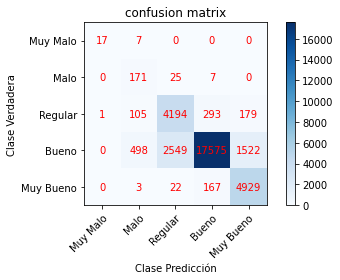

Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: 
[[   17     7     0     0     0]
 [    0   171    25     7     0]
 [    1   105  4194   293   179]
 [    0   498  2549 17575  1522]
 [    0     3    22   167  4929]]
              precision    recall  f1-score   support

           0       0.94      0.71      0.81        24
           1       0.22      0.84      0.35       203
           2       0.62      0.88      0.73      4772
           3       0.97      0.79      0.87     22144
           4       0.74      0.96      0.84      5121

    accuracy                           0.83     32264
   macro avg       0.70      0.84      0.72     32264
weighted avg       0.88      0.83      0.84     32264



In [ ]:
np.set_printoptions(precision=2)
y_test = list(map(int, y_test))
y_pred = list(map(int, y_pred))

class_names = ['Muy Malo', 'Malo', 'Regular', 'Bueno', 'Muy Bueno']
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(y_test, y_pred, classes=class_names)
plt.show()

print("Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: ")

print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=2))

In [ ]:
imps = permutation_importance(bayes, X_test, y_test)
print(imps.importances_mean)

[-0.   -0.01 -0.01 -0.   -0.01 -0.   -0.   -0.01 -0.01  0.12 -0.03 -0.01
 -0.03 -0.03 -0.01 -0.03 -0.03 -0.04  0.02  0.01 -0.   -0.  ]


# Decision Trees 

In [ ]:
treeDs = DecisionTreeClassifier()
treeDs.fit(X_train, y_train)

yt_pred = treeDs.predict(X_test)

In [ ]:
accuracy, precision, recall, f1 = accuracy_score(y_test, yt_pred), precision_score(y_test, yt_pred, average = 'weighted'), recall_score(y_test, yt_pred, average = 'weighted'), f1_score(y_test, yt_pred, average = 'weighted')
accuracy, precision, recall, f1

(0.9967765931068684,
 0.9967899124493304,
 0.9967765931068684,
 0.9967787637371189)

Se imprime la matriz de Confusión


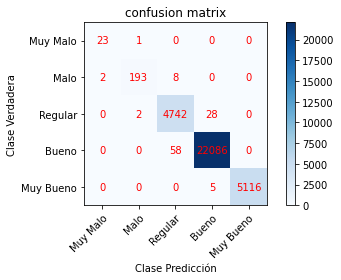

Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: 
[[   23     1     0     0     0]
 [    2   193     8     0     0]
 [    0     2  4742    28     0]
 [    0     0    58 22086     0]
 [    0     0     0     5  5116]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.98      0.95      0.97       203
           2       0.99      0.99      0.99      4772
           3       1.00      1.00      1.00     22144
           4       1.00      1.00      1.00      5121

    accuracy                           1.00     32264
   macro avg       0.98      0.98      0.98     32264
weighted avg       1.00      1.00      1.00     32264



In [ ]:
np.set_printoptions(precision=2)
y_test = list(map(int, y_test))
yt_pred = list(map(int, yt_pred))

class_names = ['Muy Malo', 'Malo', 'Regular', 'Bueno', 'Muy Bueno']
cm = confusion_matrix(y_test, yt_pred)

plot_confusion_matrix(y_test, yt_pred, classes=class_names)
plt.show()

print("Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: ")

print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_test, yt_pred, digits=2))

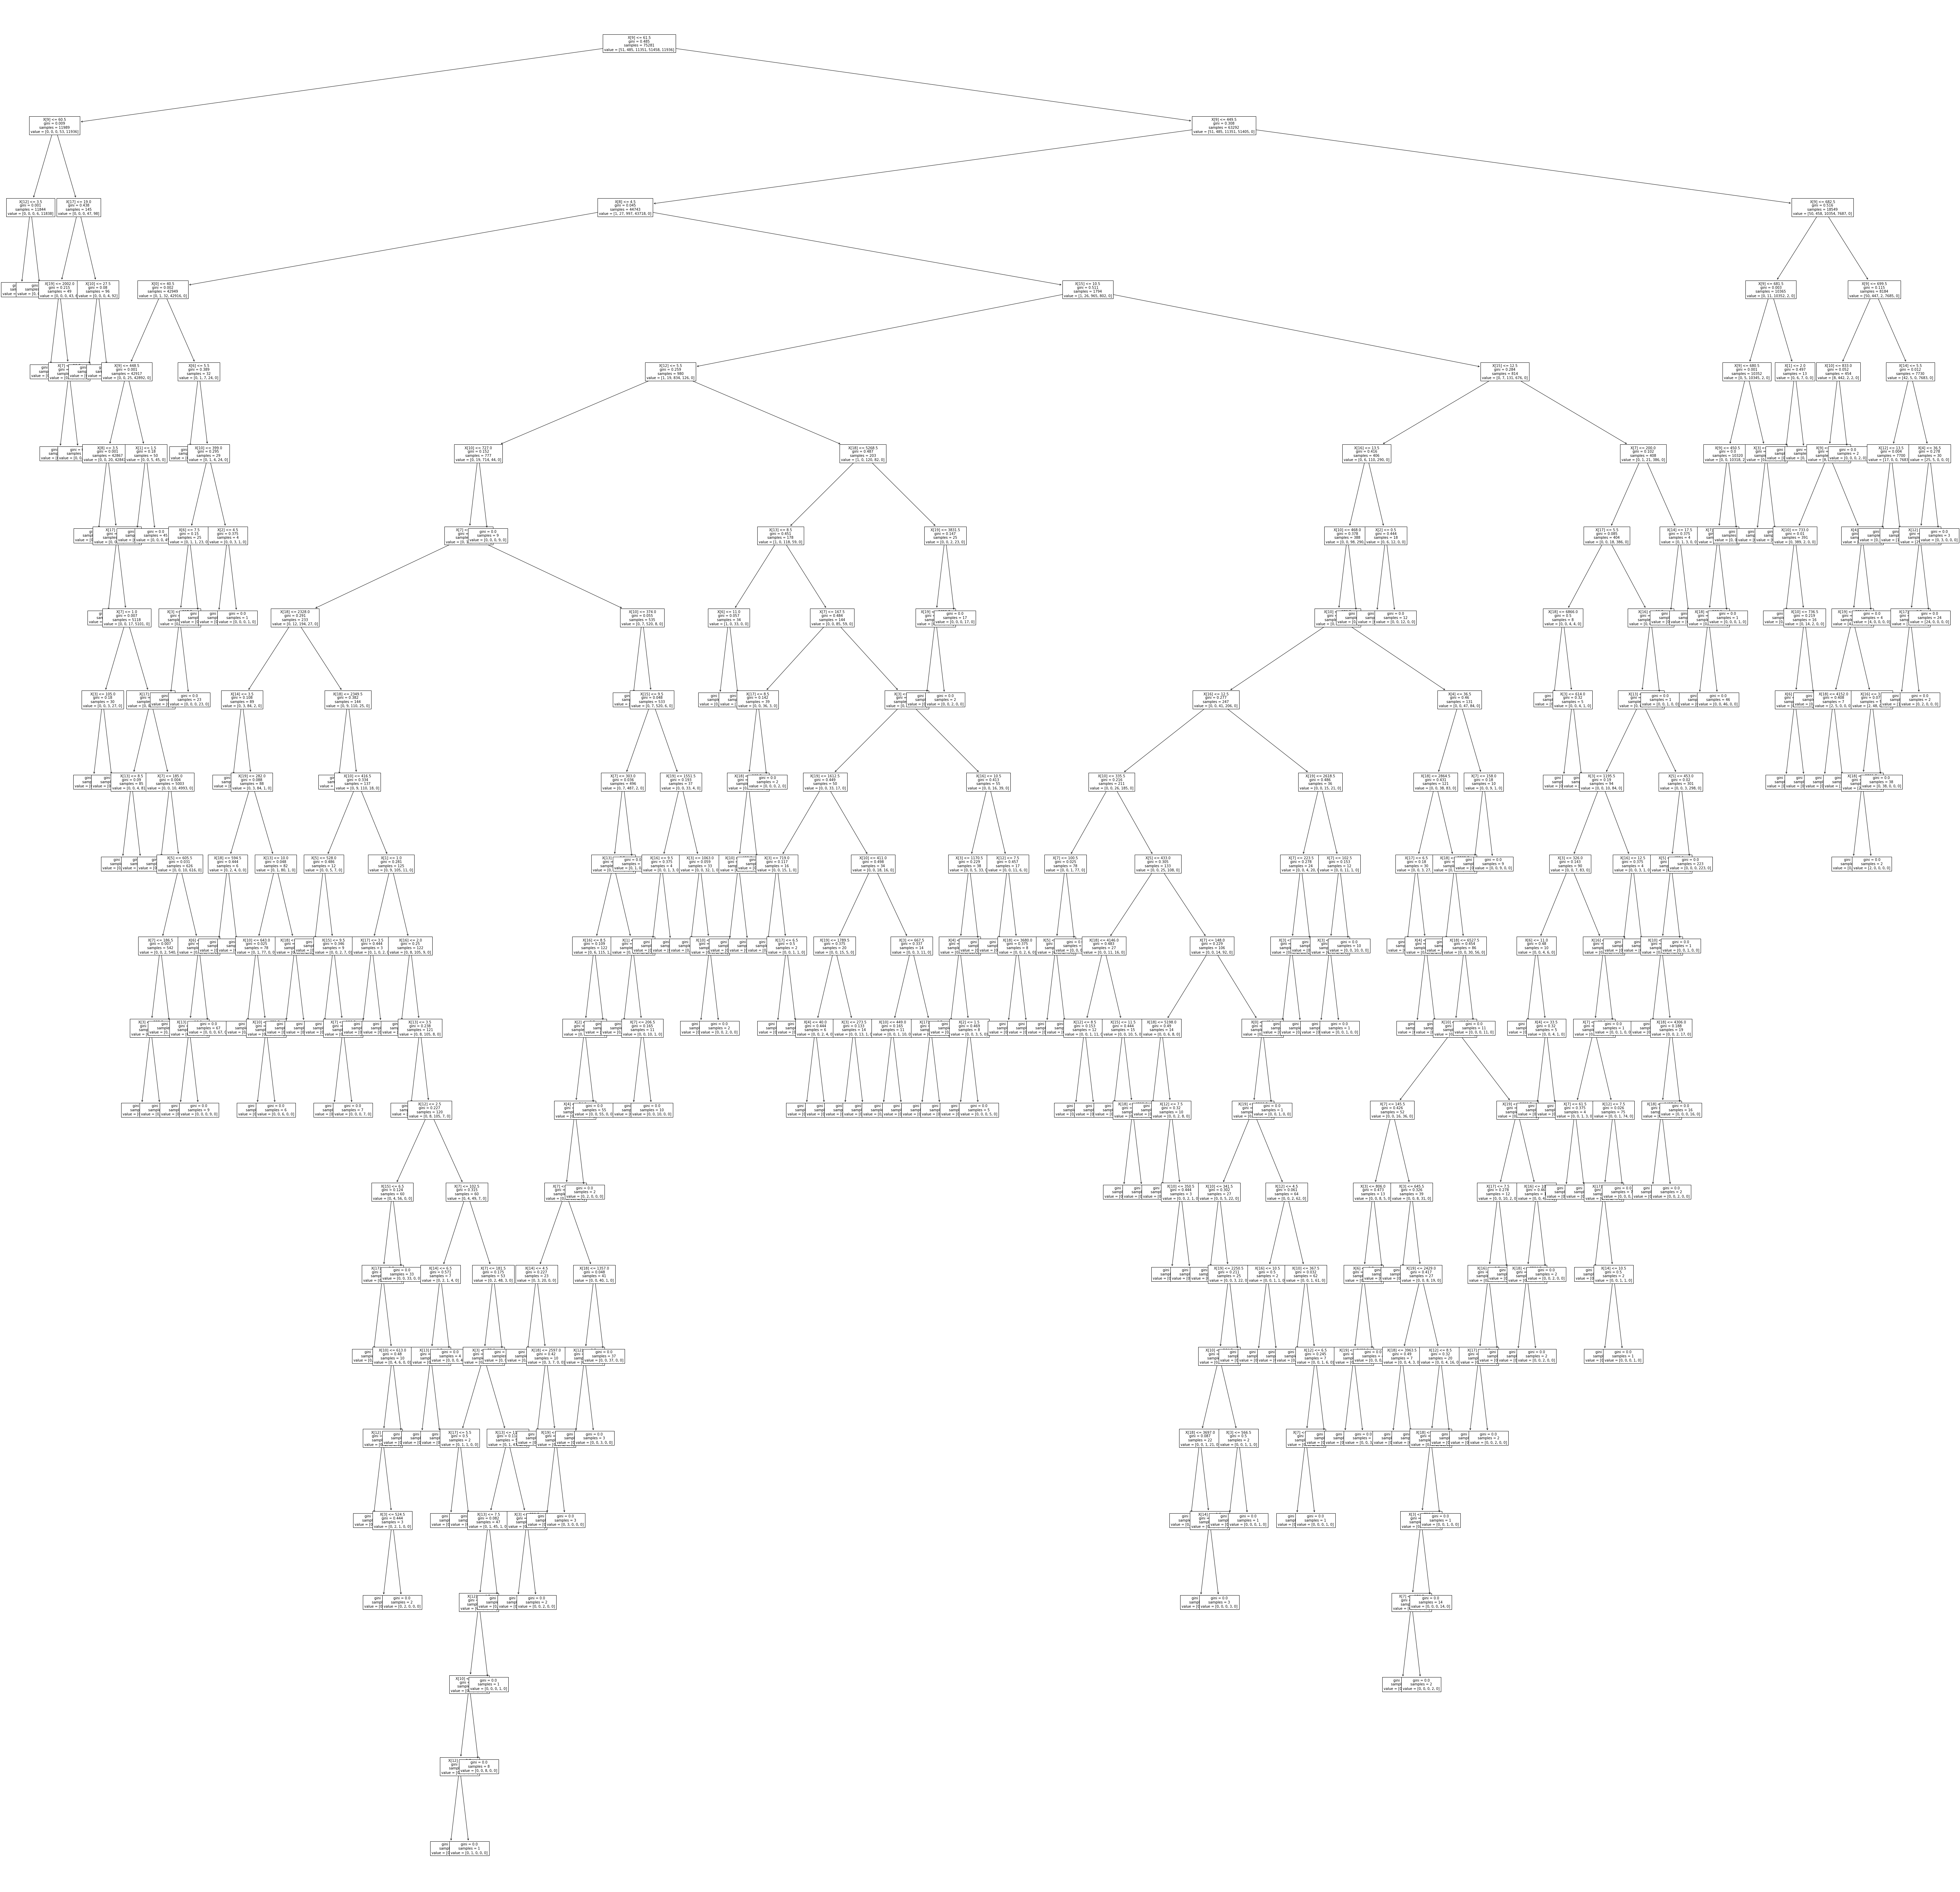

In [ ]:
plt.figure(figsize=(100,100))
tree.plot_tree(treeDs, fontsize=10)
plt.show()

In [ ]:
text_representation = tree.export_text(treeDs)
print(text_representation)

|--- feature_9 <= 61.50
|   |--- feature_9 <= 60.50
|   |   |--- feature_12 <= 3.50
|   |   |   |--- class: 3
|   |   |--- feature_12 >  3.50
|   |   |   |--- class: 4
|   |--- feature_9 >  60.50
|   |   |--- feature_17 <= 19.00
|   |   |   |--- feature_19 <= 2002.00
|   |   |   |   |--- class: 4
|   |   |   |--- feature_19 >  2002.00
|   |   |   |   |--- feature_7 <= 29.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- feature_7 >  29.50
|   |   |   |   |   |--- class: 3
|   |   |--- feature_17 >  19.00
|   |   |   |--- feature_10 <= 27.50
|   |   |   |   |--- class: 3
|   |   |   |--- feature_10 >  27.50
|   |   |   |   |--- class: 4
|--- feature_9 >  61.50
|   |--- feature_9 <= 449.50
|   |   |--- feature_8 <= 4.50
|   |   |   |--- feature_0 <= 40.50
|   |   |   |   |--- feature_9 <= 448.50
|   |   |   |   |   |--- feature_8 <= 3.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_8 >  3.50
|   |   |   |   |   |   |--- feature_17 <= 3.50
|   |   |   |  

In [ ]:
imps = permutation_importance(treeDs, X_test, y_test)
print(imps.importances_mean)

[1.67e-04 3.05e-03 2.17e-04 5.95e-04 5.02e-04 4.15e-04 3.16e-04 2.81e-03
 1.99e-02 4.94e-01 7.73e-03 0.00e+00 8.54e-02 2.94e-03 8.24e-02 7.12e-03
 4.87e-03 1.71e-02 9.61e-04 6.63e-04 0.00e+00 0.00e+00]


### Mejoramiento de hiperparámetros

Deduciendo las métricas de calidad sobre predicciones hechas al set de entrenamiento se observa que los datos están sobre-ajustados.

In [ ]:
train_pred = treeDs.predict(X_train)
accuracy, precision, recall, f1 = accuracy_score(y_train, train_pred), precision_score(y_train, train_pred, average = 'weighted'), recall_score(y_train, train_pred, average = 'weighted'), f1_score(y_train, train_pred, average = 'weighted')
accuracy, precision, recall, f1

(1.0, 1.0, 1.0, 1.0)

En efecto, se encuentra que la profundidad máxima del modelo de arbol es muy grande.

In [ ]:
treeDs.tree_.max_depth

22

Se preba nuevamente el modelo con los datos de entrenamiento

In [ ]:
treeDs = DecisionTreeClassifier(max_depth = 3, random_state= 4)
treeDs.fit(X_train, y_train)
yt_pred = treeDs.predict(X_test)

train_pred = treeDs.predict(X_train)
accuracy, precision, recall, f1 = accuracy_score(y_train, train_pred), precision_score(y_train, train_pred, average = 'weighted'), recall_score(y_train, train_pred, average = 'weighted'), f1_score(y_train, train_pred, average = 'weighted')
accuracy, precision, recall, f1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9816155470835934,
 0.9752011110479409,
 0.9816155470835934,
 0.9782319929480288)

Y luego con los datos de prueba.

In [ ]:
accuracy, precision, recall, f1 = accuracy_score(y_test, yt_pred), precision_score(y_test, yt_pred, average = 'weighted'), recall_score(y_test, yt_pred, average = 'weighted'), f1_score(y_test, yt_pred, average = 'weighted')
accuracy, precision, recall, f1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9810934787999008,
 0.9748841604041019,
 0.9810934787999008,
 0.9777773174527249)

Se observa que el mejor valor de max_depth para trabajar es 6:

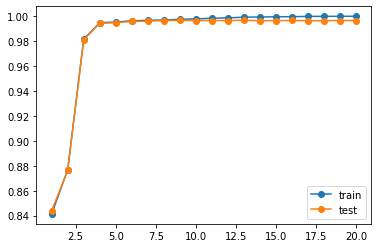

In [ ]:
train_accuracy = []
test_accuracy = []
for max_d in range(1,21):
  treeDs = DecisionTreeClassifier(max_depth = max_d, random_state= 4)
  treeDs.fit(X_train, y_train)
  tr_acc = accuracy_score(y_train, treeDs.predict(X_train))
  train_accuracy.append(tr_acc)
  te_acc = accuracy_score(y_test, treeDs.predict(X_test))
  test_accuracy.append(te_acc)

plt.plot(list(range(1,21)), train_accuracy, marker = 'o', label = 'train')
plt.plot(list(range(1,21)), test_accuracy, marker = 'o',label = 'test')
plt.legend()
plt.show()

In [ ]:
treeDs = DecisionTreeClassifier(max_depth = 6, random_state= 4)
treeDs.fit(X_train, y_train)

yt_pred = treeDs.predict(X_test)
accuracy, precision, recall, f1 = accuracy_score(y_test, yt_pred), precision_score(y_test, yt_pred, average = 'weighted'), recall_score(y_test, yt_pred, average = 'weighted'), f1_score(y_test, yt_pred, average = 'weighted')
accuracy, precision, recall, f1

(0.9958157698983388,
 0.9958184008512421,
 0.9958157698983388,
 0.9958070351561502)

Se imprime la matriz de Confusión


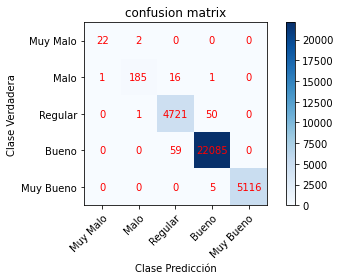

In [ ]:
plot_confusion_matrix(y_test, yt_pred, classes=class_names)
plt.show()

In [ ]:
print(classification_report(y_test, yt_pred, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.98      0.91      0.95       203
           2       0.98      0.99      0.99      4772
           3       1.00      1.00      1.00     22144
           4       1.00      1.00      1.00      5121

    accuracy                           1.00     32264
   macro avg       0.98      0.96      0.97     32264
weighted avg       1.00      1.00      1.00     32264



In [ ]:
data.columns[19]

'Air Entry Date'

In [ ]:
text_representation = tree.export_text(treeDs)
print(text_representation)

|--- feature_9 <= 61.50
|   |--- feature_9 <= 60.50
|   |   |--- feature_13 <= 3.50
|   |   |   |--- class: 3
|   |   |--- feature_13 >  3.50
|   |   |   |--- class: 4
|   |--- feature_9 >  60.50
|   |   |--- feature_17 <= 19.00
|   |   |   |--- feature_19 <= 2002.00
|   |   |   |   |--- class: 4
|   |   |   |--- feature_19 >  2002.00
|   |   |   |   |--- feature_7 <= 29.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- feature_7 >  29.50
|   |   |   |   |   |--- class: 3
|   |   |--- feature_17 >  19.00
|   |   |   |--- feature_5 <= 98.00
|   |   |   |   |--- class: 3
|   |   |   |--- feature_5 >  98.00
|   |   |   |   |--- class: 4
|--- feature_9 >  61.50
|   |--- feature_9 <= 449.50
|   |   |--- feature_8 <= 4.50
|   |   |   |--- feature_0 <= 40.50
|   |   |   |   |--- feature_9 <= 448.50
|   |   |   |   |   |--- feature_8 <= 3.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_8 >  3.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |--- featur

#K Vecinos

In [ ]:
KV = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [ ]:
yk_pred = KV.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
accuracy, precision, recall, f1 = accuracy_score(y_test, yk_pred), precision_score(y_test, yk_pred, average = 'weighted'), recall_score(y_test, yk_pred, average = 'weighted'), f1_score(y_test, yk_pred, average = 'weighted')

In [ ]:
accuracy, precision, recall, f1

In [ ]:
np.set_printoptions(precision=2)
y_test = list(map(int, y_test))
yk_pred = list(map(int, yk_pred))

class_names = ['Muy Malo', 'Malo', 'Regular', 'Bueno', 'Muy Bueno']
cm = confusion_matrix(y_test, yk_pred)

plot_confusion_matrix(y_test, yk_pred, classes=class_names)
plt.show()

print("Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: ")

print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_test, yk_pred, digits=2))

#Random Forest

In [ ]:
rand = RandomForestClassifier(n_estimators=5).fit(X_train, y_train)

In [ ]:
yr_pred = rand.predict(X_test)

In [ ]:
accuracy, precision, recall, f1 = accuracy_score(y_test, yr_pred), precision_score(y_test, yr_pred, average = 'weighted'), recall_score(y_test, yr_pred, average = 'weighted'), f1_score(y_test, yr_pred, average = 'weighted')

In [ ]:
accuracy, precision, recall, f1

(0.9974894619390032,
 0.9974898436327122,
 0.9974894619390032,
 0.9974833135718458)

Se imprime la matriz de Confusión


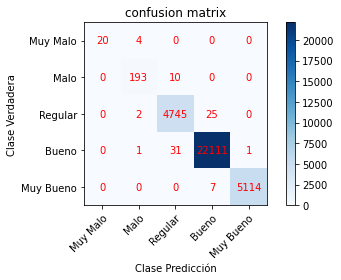

Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: 
[[   20     4     0     0     0]
 [    0   193    10     0     0]
 [    0     2  4745    25     0]
 [    0     1    31 22111     1]
 [    0     0     0     7  5114]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.96      0.95      0.96       203
           2       0.99      0.99      0.99      4772
           3       1.00      1.00      1.00     22144
           4       1.00      1.00      1.00      5121

    accuracy                           1.00     32264
   macro avg       0.99      0.96      0.97     32264
weighted avg       1.00      1.00      1.00     32264



In [ ]:
np.set_printoptions(precision=2)
y_test = list(map(int, y_test))
yr_pred = list(map(int, yr_pred))

class_names = ['Muy Malo', 'Malo', 'Regular', 'Bueno', 'Muy Bueno']
cm = confusion_matrix(y_test, yr_pred)

plot_confusion_matrix(y_test, yr_pred, classes=class_names)
plt.show()

print("Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: ")

print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_test, yr_pred, digits=2))

In [ ]:
imps = permutation_importance(rand, X_test, y_test)
print(imps.importances_mean)

[ 3.04e-04  6.20e-05  5.33e-04  6.82e-05  2.67e-04  2.79e-04  1.80e-04
  8.68e-04  1.26e-02  4.76e-01  2.39e-03  0.00e+00  3.81e-03  3.20e-03
  4.44e-02  1.11e-02  2.75e-02  3.20e-03  7.00e-04  4.40e-04  0.00e+00
 -1.86e-05]


#Bagging

In [ ]:
bagg = BaggingClassifier(n_estimators=5).fit(X_train, y_train)

In [ ]:
yb_pred = bagg.predict(X_test)

In [ ]:
accuracy, precision, recall, f1 = accuracy_score(y_test, yb_pred), precision_score(y_test, yb_pred, average = 'weighted'), recall_score(y_test, yb_pred, average = 'weighted'), f1_score(y_test, yb_pred, average = 'weighted')

In [ ]:
accuracy, precision, recall, f1

(0.9970865360773618,
 0.9970979866845714,
 0.9970865360773618,
 0.9970887358909574)

Se imprime la matriz de Confusión


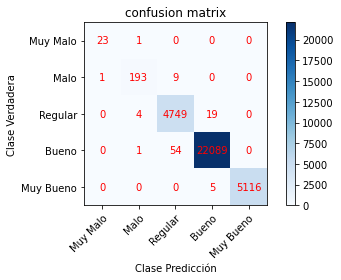

Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: 
[[   23     1     0     0     0]
 [    1   193     9     0     0]
 [    0     4  4749    19     0]
 [    0     1    54 22089     0]
 [    0     0     0     5  5116]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.97      0.95      0.96       203
           2       0.99      1.00      0.99      4772
           3       1.00      1.00      1.00     22144
           4       1.00      1.00      1.00      5121

    accuracy                           1.00     32264
   macro avg       0.98      0.98      0.98     32264
weighted avg       1.00      1.00      1.00     32264



In [ ]:
np.set_printoptions(precision=2)
y_test = list(map(int, y_test))
yb_pred = list(map(int, yb_pred))

class_names = ['Muy Malo', 'Malo', 'Regular', 'Bueno', 'Muy Bueno']
cm = confusion_matrix(y_test, yb_pred)

plot_confusion_matrix(y_test, yb_pred, classes=class_names)
plt.show()

print("Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: ")

print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_test, yb_pred, digits=2))

In [ ]:
imps = permutation_importance(bagg, X_test, y_test)
print(imps.importances_mean)

[2.54e-04 2.91e-04 9.92e-05 3.78e-04 2.73e-04 2.60e-04 3.72e-05 1.13e-03
 1.93e-02 5.05e-01 8.98e-03 0.00e+00 2.74e-03 2.10e-02 8.30e-02 1.80e-02
 2.89e-03 9.66e-03 4.40e-04 8.06e-05 0.00e+00 0.00e+00]


#Regresión Logística

In [ ]:
regr = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
yreg_pred = regr.predict(X_test)

In [ ]:
accuracy, precision, recall, f1 = accuracy_score(y_test, yreg_pred), precision_score(y_test, yreg_pred, average = 'weighted'), recall_score(y_test, yreg_pred, average = 'weighted'), f1_score(y_test, yreg_pred, average = 'weighted')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy, precision, recall, f1

(0.7994049094966527,
 0.7436826717786365,
 0.7994049094966527,
 0.7595660708482029)

Se imprime la matriz de Confusión


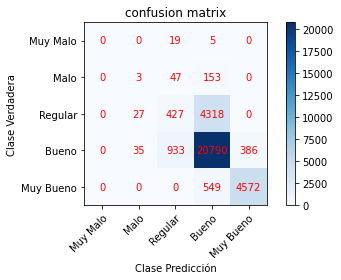

Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: 
[[    0     0    19     5     0]
 [    0     3    47   153     0]
 [    0    27   427  4318     0]
 [    0    35   933 20790   386]
 [    0     0     0   549  4572]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.05      0.01      0.02       203
           2       0.30      0.09      0.14      4772
           3       0.81      0.94      0.87     22144
           4       0.92      0.89      0.91      5121

    accuracy                           0.80     32264
   macro avg       0.41      0.39      0.39     32264
weighted avg       0.74      0.80      0.76     32264



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
np.set_printoptions(precision=2)
y_test = list(map(int, y_test))
yreg_pred = list(map(int, yreg_pred))

class_names = ['Muy Malo', 'Malo', 'Regular', 'Bueno', 'Muy Bueno']
cm = confusion_matrix(y_test, yreg_pred)

plot_confusion_matrix(y_test, yreg_pred, classes=class_names)
plt.show()

print("Imprimiendo el análisis de los resultados accuracy, precision, recall, f1: ")

print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_test, yreg_pred, digits=2))

In [ ]:
imps = permutation_importance(regr, X_test, y_test)
print(imps.importances_mean)

[-1.05e-04 -3.10e-05  5.33e-04  8.38e-03  2.48e-05  3.50e-03  5.58e-05
  1.54e-03  0.00e+00  2.28e-01  8.36e-02  0.00e+00 -1.66e-03 -2.14e-03
 -2.52e-03 -2.43e-03 -2.45e-03 -2.44e-03  4.31e-03  4.15e-03 -6.20e-06
 -6.20e-06]
